# Sales Forecast -TSA- California Housing

In [ ]:
import os

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
store_sales = pd.read_csv('train.csv')
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


#### Dropping Unecessary cols

In [ ]:
store_sales = store_sales.drop(['store','item'], axis=1)
store_sales.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


Converting Date object into datetime

In [ ]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

Conver the date into Month Period, then sum the number of items in each month

In [ ]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

Convert the resulting data column to timestamp datatypes

---



In [ ]:
# First Run, following run give attribute error!
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


In [ ]:
monthly_sales['ts'] = (monthly_sales['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s") # Method 1
monthly_sales['ts'] = monthly_sales['date'].apply(lambda x: x.timestamp()).astype(int)           # Method 2

In [ ]:
# monthly_sales['ts'] = monthly_sales['date'].apply(lambda x: x.to_pydatetime().timestamp()).astype(int)  # Method 3

In [ ]:
monthly_sales = monthly_sales.drop(['ts'], axis=1)

In [ ]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Visualization

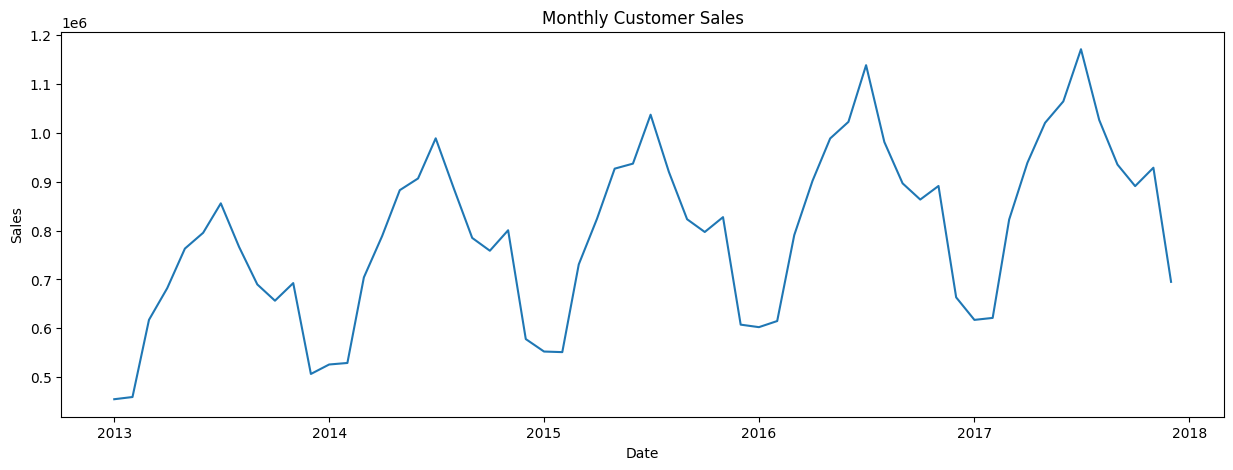

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

* Since data is showing increasing and trend over time, we need to make it <b>Stationary </b> to improve the model training process! - by differencing!
* call the difference on the sales columns to make the sales data stationary


In [ ]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


In [ ]:
# Current Month - Last Month -- Callled as diff
617382 - 459417

157965

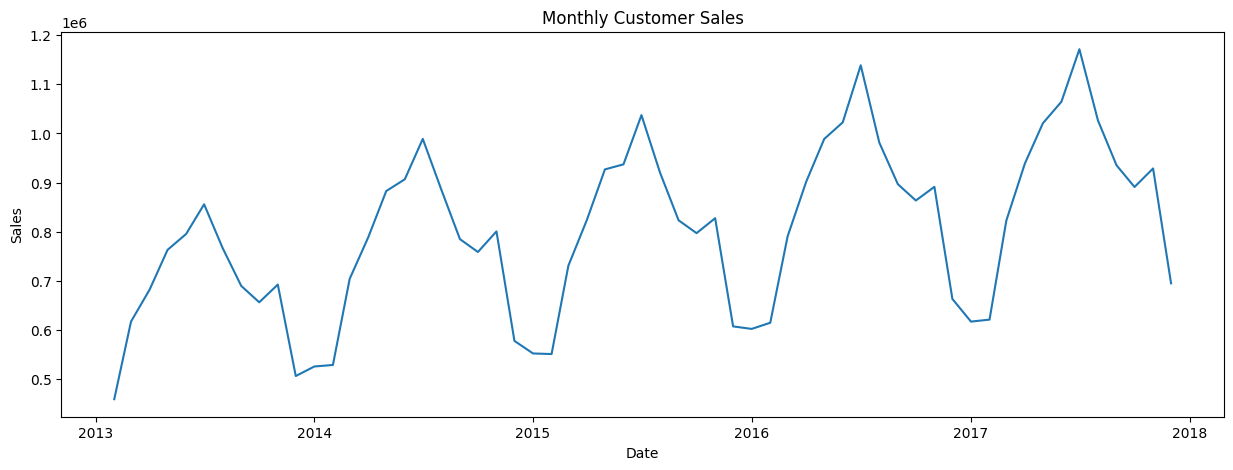

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

* Now we need to train our model to predict next month sales
* We will do the prediction by considering specific number of previous months
* For exmaple previous 12 months sales data will be consider for predicting next 12 months sales prediction

Dropping off sales & date

In [ ]:
supervised_data = monthly_sales.drop(['date','sales'], axis=1)

Preparing the supervised data

In [ ]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index()
supervised_data.head(10)

,index,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,13,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,14,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,15,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,16,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,17,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,18,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,19,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,20,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,21,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,22,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


## Train & Test Data

* Not randomized, since tsa data, order is important

In [ ]:
train_data = supervised_data[:-12] # Previsous 12 months
test_data = supervised_data[-12:]  #    

# printing
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 14)
Test Data Shape:  (12, 14)


Scaling Data

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In the supervised datafram the 1st col always corresponse to output and the remaining columns act as input features!

In [ ]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()

print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (35, 13)
X_test Shape:  (12, 13)
y_train Shape:  (35,)
y_test Shape:  (12,)


In [ ]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()  # get actual sales of last 13 months
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


## Linear Regression Model for predicting output

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

* We actually need to tranform the predicted values to their original scale. Here min max scaler has been used, so we need inverse_transform method

In [ ]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contains the input features of the test data, also the predicted output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)  # np.concatenate (package), pre: predict
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set) # inverse_transform (method)

In [ ]:
result_list = []
for index in range (0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name = 'Linear Prediction')
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)  # left & right index is matching indices
print(predict_df)

         date  Linear Prediction
0  2017-01-01       6.634403e+05
1  2017-02-01       6.173363e+05
2  2017-03-01       6.214003e+05
3  2017-04-01       8.226986e+05
4  2017-05-01       9.388952e+05
5  2017-06-01       1.020721e+06
6  2017-07-01       1.064660e+06
7  2017-08-01       1.171433e+06
8  2017-09-01       1.026440e+06
9  2017-10-01       9.353015e+05
10 2017-11-01       8.912019e+05
11 2017-12-01       9.288770e+05


* The .merge() method is used to combine DataFrames based on common columns (in this case, the index)
* In summary, this code merges the two DataFrames based on their indices. If there are matching indices, the corresponding rows will be combined into a single row in the resulting DataFrame.

### Evalulation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linear Regression MSE: ",lr_mse )
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ",lr_r2 )

Linear Regression MSE:  116721.48249618018
Linear Regression MAE:  95976.20143516926
Linear Regression R2:  0.5377535708866773


### Visualization the prediction agains actual sales

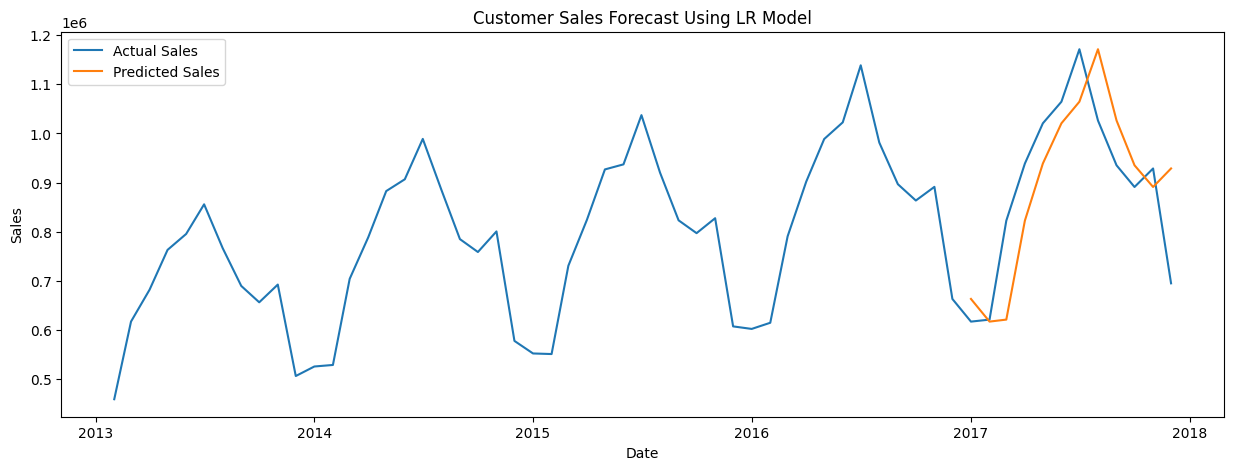

In [ ]:
plt.figure(figsize=(15,5))
# Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title('Customer Sales Forecast Using LR Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()

In [ ]:
monthly_sales.tail()

,date,sales,sales_diff
55,2017-08-01,1026403,-144990.0
56,2017-09-01,935263,-91140.0
57,2017-10-01,891160,-44103.0
58,2017-11-01,928837,37677.0
59,2017-12-01,695170,-233667.0
